In [29]:
#s3_data ="s3://aegovan-data/test_unique_pub_v3_lessnegatve_predicted_linear.json"
data_dir = "temp"

In [30]:
!rm -rf $data_dir
!mkdir $data_dir
!aws s3 cp s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190911_0942 $data_dir --recursive --exclude "*"  --include "*.json" --exclude "*vocab.json" --include "*.log"

download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190911_0942/training_scores_epoch_Objectdump_20190912_075853_3a1a9b94-edce-4556-a503-6c57ed1168c3.json to temp/training_scores_epoch_Objectdump_20190912_075853_3a1a9b94-edce-4556-a503-6c57ed1168c3.json
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190911_0942/validation_scores_epoch_Objectdump_20190912_075853_8946a305-64af-4e66-8754-1ed975a31166.json to temp/validation_scores_epoch_Objectdump_20190912_075853_8946a305-64af-4e66-8754-1ed975a31166.json
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190911_0942/run.log to temp/run.log
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190911_0942/predicted_AIMedval.json to temp/predicted_AIMedval.json
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190911_0942/predicted_AIMedtest.json to temp/predicted_AIMedtest.json


In [31]:
!ls  $data_dir

predicted_AIMedtest.json
predicted_AIMedval.json
run.log
training_scores_epoch_Objectdump_20190912_075853_3a1a9b94-edce-4556-a503-6c57ed1168c3.json
validation_scores_epoch_Objectdump_20190912_075853_8946a305-64af-4e66-8754-1ed975a31166.json


In [32]:
!head -1 $data_dir/run.log 

commit 7e3d8a5502c029e5c63985d066c3dc21f250d678


In [33]:
!head -10 $data_dir/run.log | tail -8

Date:   Wed Sep 11 19:32:29 2019 +1000

    Decrease lstm hidden layer size
{'dataset': 'PpiAimedDataset', 'trainjson': '/data/AIMedtrain.json', 'valjson': '/data/AIMedval.json', 'embedding': '/data/wikipedia-pubmed-and-PMC-w2v.bin.txt', 'embeddim': 200, 'outdir': '/data/model_PpiAimedDataset_CnnPos_190911_0942', 'epochs': 200, 'interaction_type': None, 'log_level': 'INFO'}
2019-09-11 09:42:28,462 - __main__ - INFO - The embedding header is 5443656 200

2019-09-11 09:42:28,462 - algorithms.RelationExtractorBiLstmNetwork - INFO - The text feature is index 0, the feature lengths are [150   1   1]
2019-09-11 09:42:28,463 - algorithms.RelationExtractorBiLstmNetwork - INFO - Word embedding size is 200, pos embedding size is 6, totaldim is 206, hidden_size  100


In [34]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [35]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [36]:
import glob

results_file = "./{}/predicted_AIMedtest.json".format(data_dir)
validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(data_dir))[0]
train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(data_dir))[0]


pos_label = True

In [37]:
#download_single_file(s3_data, results_file)

In [38]:
import pandas as pd

In [39]:
df_results = pd.read_json(results_file)
df_results["actual"] = df_results["isValid"]

In [40]:
df_results.head(n=3)

,docid,isValid,line_no,participant1,participant2,passage,predicted,confidence_scores,confidence_true,confidence_false,actual
0,abstract_11780382,False,6,IFN - alpha,IL - 4,"Cytokines measurements during IFN - alpha treatment showed a trend to decreasing levels of IL - 4 at 4 , 12 , and 24 weeks .",False,"{'False': 10.2667818069, 'True': -8.8057451248}",0.000150,28761.179044,False
1,abstract_11780382,False,7,IFN - alpha,IFN - gamma,Levels of IFN - gamma were slightly increased following IFN - alpha treatment ( P = 0.09 ) .,False,"{'False': 9.5338916779, 'True': -8.166425705}",0.000284,13820.270606,False
1020,abstract_for_1833068,False,1,CDC2,cyclin E,"TI - Human cyclin E , a new cyclin that interacts with two members of the CDC2 gene family .",False,"{'False': 13.3414592743, 'True': -9.973110199}",0.000047,622475.328928,False


In [41]:
df_results.columns


Index(['docid', 'isValid', 'line_no', 'participant1', 'participant2',
       'passage', 'predicted', 'confidence_scores', 'confidence_true',
       'confidence_false', 'actual'],
      dtype='object')

## Analyse Results

In [42]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [43]:
df = df_results

In [44]:
df_results.shape

(590, 11)

In [45]:
import math

# This is log softmax, convert to softmax prob
df["true"]  =df["confidence_scores"].apply(lambda x: math.exp(x["True"]))
df["false"]  =df["confidence_scores"].apply(lambda x: math.exp(x["False"]))

df[ ["true", "false", "actual", "predicted", "confidence_scores"]].sort_values(["true"], ascending=False).head(n=3)

,true,false,actual,predicted,confidence_scores
1881,296.950049,0.000003,True,True,"{'False': -12.805332183800001, 'True': 5.6935639381000005}"
2237,197.879774,0.000009,True,True,"{'False': -11.594827652, 'True': 5.2876596451}"
1858,97.059904,0.000009,True,True,"{'False': -11.6139221191, 'True': 4.5753283501}"


In [46]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df["actual"], df["predicted"], sample_weight=None)  
accuracy = accuracy_score(df["actual"], df["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))



The F1 score is 0.5 and the accuracy is 0.8338983050847457


In [47]:
!pip install scikit-plot==0.3.7

awsebcli 3.12.4 has requirement requests<=2.9.1,>=2.6.1, but you'll have requests 2.18.4 which is incompatible.
spacy 2.1.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.1 which is incompatible.
blis 0.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.1 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


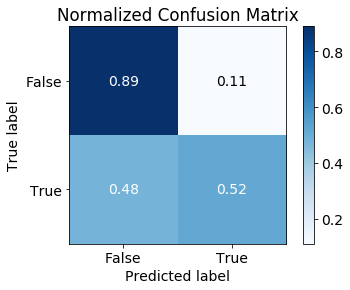

In [48]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True )
plt.show()

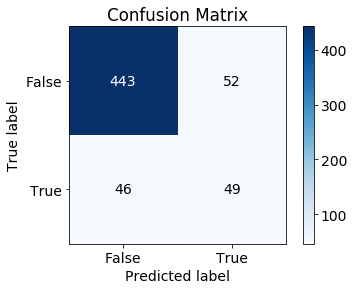

In [49]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=False )
plt.show()

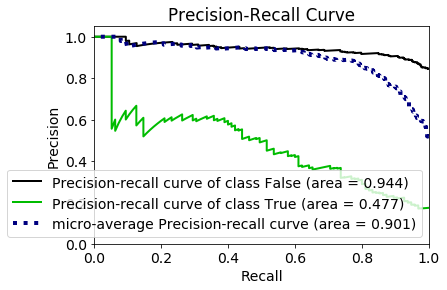

In [50]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_precision_recall(df["actual"], df[["false", "true"]])

## Training / Validation epoch fit

In [51]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [52]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit["score"] = df_train_fit["score"] * 100
df_train_fit.sort_values(["score"], ascending=False).head(n=10)


,epoch,loss,score
53,53,0.571729,99.574468
50,50,0.345922,99.433428
49,49,0.478285,99.288762
48,48,0.601827,99.150142
51,51,1.174974,98.734177
47,47,1.023985,98.571429
38,38,1.308520,98.016997
41,41,1.229629,98.011364
46,46,1.625579,97.727273
37,37,1.351546,97.720798


In [58]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit["score"] = df_val_fit["score"] * 100
df_val_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
32,32,9.440964,54.000000
30,30,7.699352,51.485149
43,43,11.461142,49.122807
52,52,11.129231,49.056604
33,33,9.423465,48.888889
41,41,10.252062,48.837209
27,27,8.893841,48.192771
28,28,7.912841,47.619048
46,46,9.901287,47.619048
21,21,7.287663,47.482014


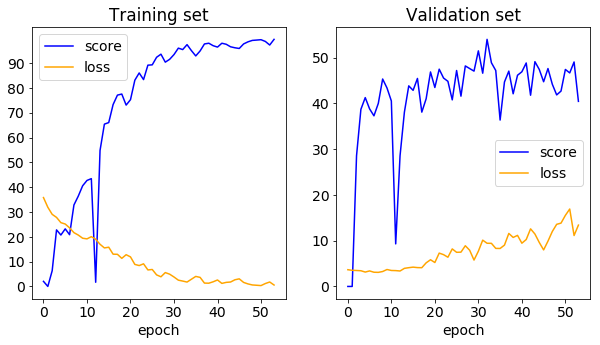

In [54]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="score", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="loss", ax = ax[0], color="orange")
ax[0].set_title("Training set")
ax[0].yaxis.set_major_locator(plt.FixedLocator( range(0, 100, 10)))

df_val_fit.plot.line(x="epoch", y="score", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="loss", ax = ax[1], color ="orange")

ax[1].set_title("Validation set")
ax[1].yaxis.set_major_locator(plt.FixedLocator(range(0, 100,10)))



plt.show()

### Threshold 

In [55]:
threshold = .95
df_trues = df.query("true > {}".format(threshold))
df_trues.shape

(99, 13)

In [56]:
from sklearn.metrics import f1_score, accuracy_score, precision_score

f1 = f1_score(df_trues["actual"], df_trues["predicted"])  
accuracy = accuracy_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)
precision = precision_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)


print("The F1 score is {} and the accuracy is {}, precision {}".format(f1, accuracy, precision))

The F1 score is 0.6620689655172414 and the accuracy is 0.5050505050505051, precision 0.5
